In [1]:
# import standard libraries

import pandas as pd
import gzip         # reading compressed files.
import ast          # evaluating literal expressions

# Adjusting some visuals

pd.set_option('display.max_colwidth', 100)  # Set the maximum width of a column to display (None for unlimited)

pd.set_option('display.max_rows', 6)  # Set the maximum number of rows to display

pd.set_option('display.max_columns', None)  # Set the maximum number of columns to display (None for unlimited)

### The data: user_items.json.gz

In [2]:
# first tried to open gz file with the simple procedure. It was impossible due to falied encoding.
# Introducing gzip and ast solved the problem.

# both user_reviews and users_items are in the same situation, so i put the open procedure inside a function:

def open_jsongz(path):

    rows = []

    with gzip.open(path, 'rt', encoding='utf-8') as file:
        for line in file.readlines():
            rows.append(ast.literal_eval(line)) # is used to safely interpret the content of each line as a Python literal
                                                # (likely a dictionary).

    return  pd.DataFrame(rows)

users_items = open_jsongz('../data/users_items.json.gz')

In [3]:
# keep just relevat columns for the analysis

users_items.drop(['items_count','steam_id', 'user_url'], axis=1, inplace=True)

In [4]:
unpacked_list = []

# First colum refer to df, the 3 columns left, are keys indide dictionary for 4th df column

columns_names = ['user_id', 'item_id', 'item_name', 'playtime_forever']

def get_data(row):
    for users_items in row['items']:
        unpacked_list.append([
            row[columns_names[0]],
            users_items[columns_names[1]],
            users_items[columns_names[2]],
            users_items[columns_names[3]]])

users_items.apply(get_data, axis=1)

unpacked_items = pd.DataFrame(unpacked_list, columns=columns_names)

In [5]:
unpacked_items

,user_id,item_id,item_name,playtime_forever
0,76561197970982479,10,Counter-Strike,6
1,76561197970982479,20,Team Fortress Classic,0
2,76561197970982479,30,Day of Defeat,7
...,...,...,...,...
5153206,76561198329548331,388490,One Way To Die: Steam Edition,3
5153207,76561198329548331,521570,You Have 10 Seconds 2,4
5153208,76561198329548331,519140,Minds Eyes,3


In [8]:
unpacked_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153209 entries, 0 to 5153208
Data columns (total 4 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   user_id           object
 1   item_id           object
 2   item_name         object
 3   playtime_forever  int64 
dtypes: int64(1), object(3)
memory usage: 157.3+ MB


In [10]:
# Here we found a problem to further deploy process.
# Free account cloud server (render.com) limits to 512Mb the total memory available to upload/process.
# Memory ussage of 157 Mb is clearly a problem both to render.com but to github.com as well, as the maximun
# file size to upload (and from there to feed render.com) is up to 100Mb.

# So two aproaches were used:
# 1) Trim all useless info for the pourpouse of the answers to respond.
# 2) Compress the file at it's most.

In [6]:
# Erase all rows where 'playtime' is zero

unpacked_items = unpacked_items.drop(unpacked_items[unpacked_items['playtime_forever']==0].index)
unpacked_items

,user_id,item_id,item_name,playtime_forever
0,76561197970982479,10,Counter-Strike,6
2,76561197970982479,30,Day of Defeat,7
8,76561197970982479,300,Day of Defeat: Source,4733
...,...,...,...,...
5153206,76561198329548331,388490,One Way To Die: Steam Edition,3
5153207,76561198329548331,521570,You Have 10 Seconds 2,4
5153208,76561198329548331,519140,Minds Eyes,3


In [8]:
# For later use, this result will be stored.

unpacked_items[['user_id', 'item_id', 'playtime_forever']].to_parquet('../light_data/user_id&playtime.parquet', engine='fastparquet')

In [9]:
# For later use, this result will be stored.

genre_df = pd.read_csv('../light_data/playtimegenre.csv')
genre_df

,item_id,release_date_imputed,tags&genres
0,761140,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Simulation']"
1,643980,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', 'Card Game', 'Trading Card Game', 'Turn-Based', 'Fa..."
2,670290,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casual', 'Indie', 'Multiplayer']"
...,...,...,...
32128,610660,2018-01-04,"['Indie', 'Simulation', 'Racing']"
32129,658870,2017-09-02,"['Indie', 'Casual', 'Puzzle', 'Singleplayer', 'Atmospheric', 'Relaxing']"
32130,681550,2018-01-03,"['Early Access', 'Adventure', 'Indie', 'Action', 'Simulation', 'VR']"


In [10]:
# Drop all rows with no genre

genre_df = genre_df.drop(genre_df[genre_df['tags&genres'].isna()].index)
genre_df

,item_id,release_date_imputed,tags&genres
0,761140,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Simulation']"
1,643980,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', 'Card Game', 'Trading Card Game', 'Turn-Based', 'Fa..."
2,670290,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casual', 'Indie', 'Multiplayer']"
...,...,...,...
32128,610660,2018-01-04,"['Indie', 'Simulation', 'Racing']"
32129,658870,2017-09-02,"['Indie', 'Casual', 'Puzzle', 'Singleplayer', 'Atmospheric', 'Relaxing']"
32130,681550,2018-01-03,"['Early Access', 'Adventure', 'Indie', 'Action', 'Simulation', 'VR']"


In [11]:
# Change date-like string into actual date format

genre_df['release_date_imputed'] = pd.to_datetime(genre_df['release_date_imputed'], format='%Y-%m-%d', errors='coerce')
genre_df

,item_id,release_date_imputed,tags&genres
0,761140,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Simulation']"
1,643980,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', 'Card Game', 'Trading Card Game', 'Turn-Based', 'Fa..."
2,670290,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casual', 'Indie', 'Multiplayer']"
...,...,...,...
32128,610660,2018-01-04,"['Indie', 'Simulation', 'Racing']"
32129,658870,2017-09-02,"['Indie', 'Casual', 'Puzzle', 'Singleplayer', 'Atmospheric', 'Relaxing']"
32130,681550,2018-01-03,"['Early Access', 'Adventure', 'Indie', 'Action', 'Simulation', 'VR']"


In [12]:
# Change date format just to get the year

genre_df['year'] = genre_df['release_date_imputed'].dt.year
genre_df.drop('release_date_imputed', axis=1, inplace=True)
genre_df

,item_id,tags&genres,year
0,761140,"['Strategy', 'Action', 'Indie', 'Casual', 'Simulation']",2018
1,643980,"['Free to Play', 'Strategy', 'Indie', 'RPG', 'Card Game', 'Trading Card Game', 'Turn-Based', 'Fa...",2018
2,670290,"['Free to Play', 'Simulation', 'Sports', 'Casual', 'Indie', 'Multiplayer']",2017
...,...,...,...
32128,610660,"['Indie', 'Simulation', 'Racing']",2018
32129,658870,"['Indie', 'Casual', 'Puzzle', 'Singleplayer', 'Atmospheric', 'Relaxing']",2017
32130,681550,"['Early Access', 'Adventure', 'Indie', 'Action', 'Simulation', 'VR']",2018


In [13]:
# Before merge, we need to match types

unpacked_items['item_id'].info()

<class 'pandas.core.series.Series'>
Index: 3285246 entries, 0 to 5153208
Series name: item_id
Non-Null Count    Dtype 
--------------    ----- 
3285246 non-null  object
dtypes: object(1)
memory usage: 50.1+ MB


In [14]:
genre_df['item_id'].info()

<class 'pandas.core.series.Series'>
Index: 31969 entries, 0 to 32130
Series name: item_id
Non-Null Count  Dtype
--------------  -----
31969 non-null  int64
dtypes: int64(1)
memory usage: 499.5 KB


In [15]:
# Convert the 'item_id' column in 'unpacked_items' to int64

unpacked_items['item_id'] = unpacked_items['item_id'].astype(int)

# Merge dataframes on the 'item_id' column

merged_df = pd.merge(unpacked_items, genre_df, on='item_id')
merged_df

,user_id,item_id,item_name,playtime_forever,tags&genres,year
0,76561197970982479,10,Counter-Strike,6,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'Classic', 'Team-Based', 'Competitive', 'First-Perso...",2000
1,doctr,10,Counter-Strike,93,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'Classic', 'Team-Based', 'Competitive', 'First-Perso...",2000
2,corrupted_soul,10,Counter-Strike,108,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'Classic', 'Team-Based', 'Competitive', 'First-Perso...",2000
...,...,...,...,...,...,...
2868031,76561198146468235,367090,Robot Roller-Derby Disco Dodgeball Soundtrack,1,"['Indie', 'Sports', 'Action']",2015
2868032,massimo23,448540,TERROR LAB,1,"['Indie', 'Adventure', 'Psychological Horror', 'Horror', 'Survival Horror']",2016
2868033,danebuchanan,485270,Arachnophobia,7,"['Casual', 'Simulation', 'Psychological Horror', 'Horror', 'VR']",2018


In [19]:
# For later use, this result will be stored.
# (this is done locally before uploading for deploy, so no much compression needed).

light_unpacked = merged_df[['user_id', 'item_id', 'playtime_forever']]
light_unpacked.to_csv("../light_data/function2.csv")

In [20]:
light_unpacked.isna().sum()

user_id             0
item_id             0
playtime_forever    0
dtype: int64

In [21]:
# Group by the 'item_id' column and sum the 'playtime_forever' column

item_id_playtime = light_unpacked.groupby('item_id')['playtime_forever'].sum().reset_index()
item_id_playtime

,item_id,playtime_forever
0,10,17386015
1,20,961702
2,30,758991
...,...,...
8516,527890,1
8517,527900,44
8518,528660,182


In [22]:
# We now convert the 'playtime' to hours and minutes. Later, we will add them up. 

data = []
def convert_minutes_to_hours_and_minutes(row):
    item_id = row['item_id']
    hours = row['playtime_forever'] // 60
    remaining_minutes = row['playtime_forever'] % 60
    return data.append([item_id, hours, remaining_minutes])

item_id_playtime.apply(convert_minutes_to_hours_and_minutes,axis=1)

hors_and_minutes_by_Item_id = pd.DataFrame(data, columns = ['item_id', 'hours', 'minutes'])
hors_and_minutes_by_Item_id

,item_id,hours,minutes
0,10,289766,55
1,20,16028,22
2,30,12649,51
...,...,...,...
8516,527890,0,1
8517,527900,0,44
8518,528660,3,2


In [23]:
# For later use, this result will be stored.

hors_and_minutes_by_Item_id.to_csv('../light_data/item_id&playtime.csv', index=False)

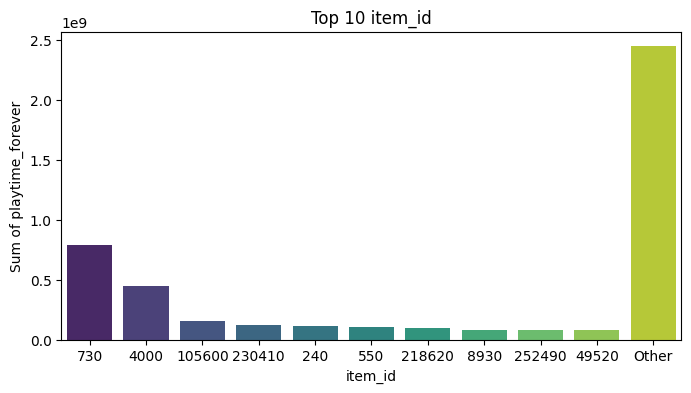

In [24]:
# Plot some insights for data


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the DataFrame by 'playtime_forever' in descending order

item_id_playtime = item_id_playtime.sort_values(by='playtime_forever', ascending=False)

# Select the top 10 categories and sum the rest

top_categories = item_id_playtime.head(10)
other_category = pd.DataFrame({'item_id': ['Other'], 'playtime_forever': [item_id_playtime.iloc[10:]['playtime_forever'].sum()]})

# Concatenate the top categories and 'Other'

new_df = pd.concat([top_categories, other_category])

# Plot the data

plt.figure(figsize=(8, 4))
sns.barplot(x='item_id', y='playtime_forever', data=new_df, palette='viridis')
plt.title('Top 10 item_id')
plt.xlabel('item_id')
plt.ylabel('Sum of playtime_forever')
plt.show()


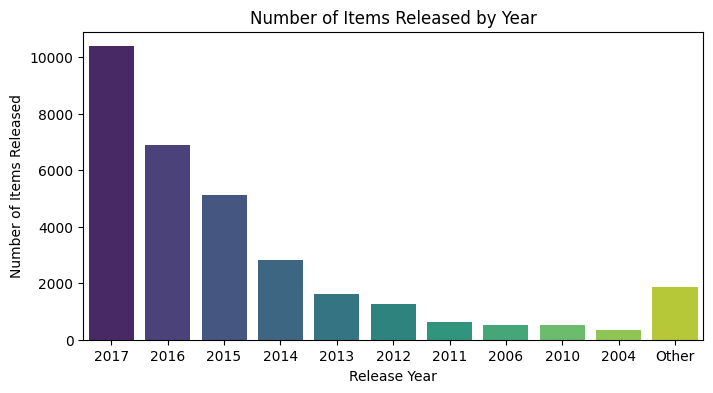

In [26]:
# Count the number of items released each year

items_by_year = genre_df.groupby('year')['item_id'].count().reset_index()

# Sort the DataFrame by 'item_id' in descending order

items_by_year = items_by_year.sort_values(by='item_id', ascending=False)

# Select the top 10 years and sum the rest

top_years = items_by_year.head(10)
other_years = pd.DataFrame({'year': ['Other'], 'item_id': [items_by_year.iloc[10:]['item_id'].sum()]})

# Concatenate the top years and 'Other'

items_by_year = pd.concat([top_years, other_years])

# Plot the data

plt.figure(figsize=(8, 4))
sns.barplot(x='year', y='item_id', data=items_by_year, palette='viridis')
plt.title('Number of Items Released by Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Items Released')
plt.show()